# Imports

In [195]:
from paddleocr import PaddleOCR

import math
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
def show_img(img, cmap=None):
    fig, ax  = plt.subplots()

    ax.imshow(img, cmap=cmap)
    ax.axis("off")

    plt.show()

# Image

In [253]:
# IMG = "../data/photo_2024-05-23_15-18-57.jpg"
IMG = "../data/GeoVision dataset/well_3_old.jpg"

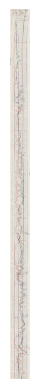

(31785, 1650, 3)


In [254]:
orig_img = cv2.imread(IMG)[..., ::-1]
# img = cv2.resize(img, (1280, 720))

show_img(orig_img)
print(orig_img.shape)

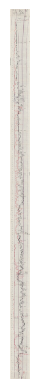

In [255]:
img = orig_img.copy()

# THRESHOLD = 180

# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)

# gray_img[gray_img < THRESHOLD] = 0
# gray_img[gray_img >= THRESHOLD] = 255

# img = gray_img.copy()

kernel = np.ones((3, 3), dtype=np.uint8)

img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel=kernel, iterations=1)

show_img(img, cmap="Greys_r")

# Paddle

In [256]:
ocr = PaddleOCR(
    ocr_version="PP-OCRv4",
    use_angle_cls=True,
    lang="en",
    use_gpu=False,
    show_log=False,
)

In [257]:
height = img.shape[0]
step = 500
n_steps = math.ceil(height / step)

boxes_list = []
texts_list = []

for i in range(n_steps):
    bottom = max(0, i * step - 100)
    top = (i + 1) * step

    pred = ocr.ocr(img[bottom:top])

    boxes = [[[box[0], box[1] + bottom] for box in p[0]] for p in pred[0]]
    texts = [p[1][0] for p in pred[0]]

    boxes_list.extend(boxes)
    texts_list.extend(texts)

In [258]:
boxes = [p[0] for p in pred[0]]
texts = [p[1][0] for p in pred[0]]
scores = [p[1][1] for p in pred[0]]

In [259]:
boxes_list

[[[265.0, 31.0], [533.0, 35.0], [532.0, 77.0], [264.0, 73.0]],
 [[1185.0, 50.0], [1506.0, 54.0], [1505.0, 96.0], [1184.0, 92.0]],
 [[252.0, 92.0], [488.0, 98.0], [487.0, 139.0], [251.0, 133.0]],
 [[750.0, 90.0], [1054.0, 99.0], [1053.0, 146.0], [749.0, 137.0]],
 [[252.0, 138.0], [473.0, 146.0], [472.0, 188.0], [250.0, 180.0]],
 [[753.0, 142.0], [1099.0, 150.0], [1098.0, 191.0], [753.0, 184.0]],
 [[1227.0, 147.0], [1441.0, 157.0], [1439.0, 193.0], [1225.0, 184.0]],
 [[257.0, 189.0], [477.0, 198.0], [475.0, 240.0], [256.0, 230.0]],
 [[757.0, 194.0], [966.0, 202.0], [965.0, 238.0], [756.0, 231.0]],
 [[1225.0, 196.0], [1460.0, 203.0], [1458.0, 243.0], [1223.0, 236.0]],
 [[253.0, 243.0], [588.0, 239.0], [588.0, 281.0], [253.0, 285.0]],
 [[246.0, 286.0], [610.0, 292.0], [610.0, 334.0], [246.0, 328.0]],
 [[745.0, 296.0], [1035.0, 279.0], [1037.0, 326.0], [748.0, 343.0]],
 [[987.0, 305.0], [1088.0, 296.0], [1090.0, 326.0], [990.0, 334.0]],
 [[254.0, 339.0], [607.0, 339.0], [607.0, 380.0], [254

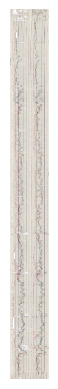

In [260]:
img_copy = img.copy()
NARROW = 1
THRESHOLD = 0.1

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (0, 0, 255)
thickness = 1
lineType = 2

for box, txt in zip(boxes_list, texts_list):
    x1, y1 = box[0]
    x2, y2 = box[2]
    x1, y1 = int(x1 - NARROW), int(y1 - NARROW) 
    x2, y2 = int(x2 - NARROW), int(y2 - NARROW)


    cv2.rectangle(
        img_copy,
        (x1, y1),
        (x2, y2),
        (255, 255, 255),
        -1,
    )
    cv2.putText(
        img_copy,
        txt,
        (x1, y2),
        font,
        fontScale,
        fontColor,
        thickness,
        lineType,
    )


# cv2.imwrite("../data/paddle_well3_500.png", np.hstack([img_copy, img])[..., ::-1])
show_img(np.hstack([img_copy, img]), cmap="Greys_r")

# Vertical Binning (Axes tick labels)

In [261]:
bins = 10
win_size = int(img.shape[1] / bins)

detects_bins = {}

for i in range(bins):
    left = max(0, i * win_size - 20)
    right = (i + 1) * win_size

    detects = [(box, text) for box, text in zip(boxes_list, texts_list) if left <= box[0][0] <= right]

    detects_bins[i] = {"left": left, "right": right, "detects": list(detects)}

max_i = 0
max_ = 0

print("| Bin |  (l, r)  | # detections")
for k, v in detects_bins.items():
    print(f"Bin #{k} - ({v['left']}, {v['right']}) - {len(v['detects'])}")

    if len(v["detects"]) > max_:
        max_ = len(v["detects"])
        max_i = k

print(f"Max detections in Bin #{max_i} ({max_})")

| Bin |  (l, r)  | # detections
Bin #0 - (0, 165) - 197
Bin #1 - (145, 330) - 18
Bin #2 - (310, 495) - 15
Bin #3 - (475, 660) - 35
Bin #4 - (640, 825) - 19
Bin #5 - (805, 990) - 21
Bin #6 - (970, 1155) - 26
Bin #7 - (1135, 1320) - 30
Bin #8 - (1300, 1485) - 7
Bin #9 - (1465, 1650) - 3
Max detections in Bin #0 (197)


In [262]:
axes = dict(detects_bins[max_i])

axes["detects"] = [
    (box, int(text)) for box, text in axes["detects"]
    if text.isnumeric() 
    ]

axes = axes["detects"]

In [263]:
axes = pd.DataFrame(axes)
axes.columns = ["box", "depth"]
axes["height"] = axes["box"].apply(lambda x: x[0][1])
axes

,box,depth,height
0,"[[129.0, 1377.0], [191.0, 1377.0], [191.0, 141...",20,1377.0
1,"[[127.0, 1541.0], [177.0, 1541.0], [177.0, 156...",30,1541.0
2,"[[134.0, 1852.0], [194.0, 1852.0], [194.0, 188...",50,1852.0
3,"[[132.0, 2007.0], [194.0, 2007.0], [194.0, 204...",60,2007.0
4,"[[134.0, 2162.0], [191.0, 2162.0], [191.0, 219...",70,2162.0
...,...,...,...
171,"[[125.0, 30504.0], [210.0, 30504.0], [210.0, 3...",1820,30504.0
172,"[[125.0, 30814.0], [229.0, 30814.0], [229.0, 3...",7890,30814.0
173,"[[121.0, 30971.0], [221.0, 30975.0], [219.0, 3...",1900,30971.0
174,"[[107.0, 31131.0], [196.0, 31124.0], [199.0, 3...",1910,31131.0


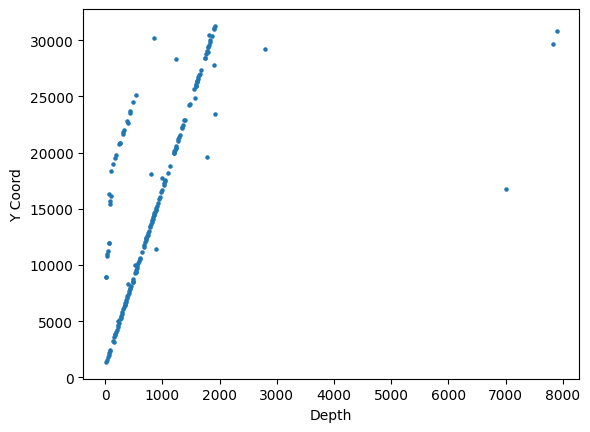

In [264]:
plt.scatter(axes["depth"], axes["height"], s=5)
plt.xlabel("Depth")
plt.ylabel("Y Coord")
plt.show()

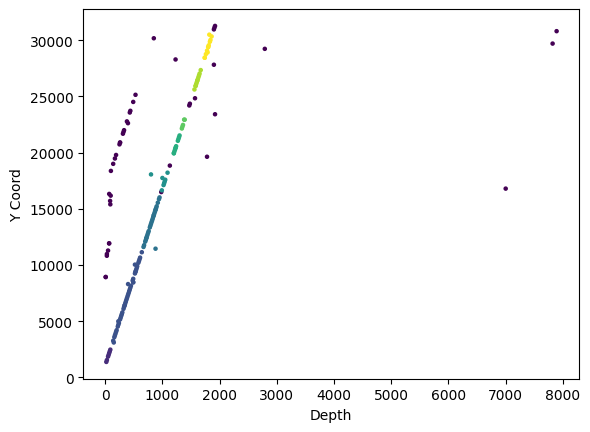

[ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1  1 -1  2  2  2 -1 -1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2 -1  2  2 -1 -1 -1
  3 -1  3  3  3  3  3  3  3 -1 -1 -1 -1 -1 -1  4  4  4  4  4  4  4 -1 -1
 -1  4  4  4  4 -1 -1 -1  5  5  5 -1 -1  5  5 -1 -1 -1 -1 -1 -1 -1 -1  6
  6  6  6  6  6  6  6  6  6  6  6 -1 -1  7  7  7  7  7 -1  7  7  7 -1  7
  7 -1  7  7 -1 -1 -1 -1]


In [265]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=500)


classes = dbscan.fit_predict(axes[["depth", "height"]])

plt.scatter(axes["depth"], axes["height"], s=5, c=classes)
plt.xlabel("Depth")
plt.ylabel("Y Coord")
plt.show()

print(classes)

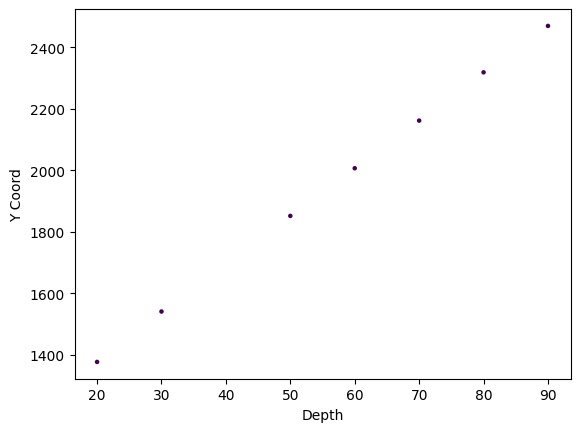

In [266]:
axes["class"] = classes

sample = axes[axes["class"] == 0]

plt.scatter(sample["depth"], sample["height"], s=5, c=sample["class"])
plt.xlabel("Depth")
plt.ylabel("Y Coord")
plt.show()

In [267]:
axes["class"].value_counts()

class
 1    48
-1    44
 2    29
 6    12
 7    12
 4    11
 3     8
 0     7
 5     5
Name: count, dtype: int64

In [268]:
from sklearn.linear_model import Ridge

lr = Ridge(alpha=100)

lr.fit(sample[["height"]].to_numpy(), sample[["depth"]].to_numpy())

lr.coef_[0][0], lr.intercept_[0]

(0.06410855964322608, -68.5831866831725)

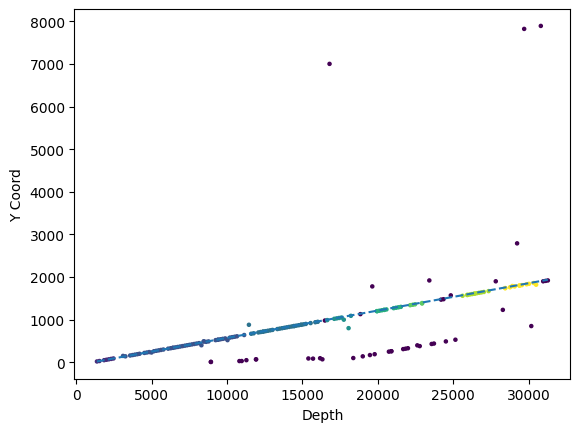

In [269]:
min_i, max_i = np.argmin(axes["height"]), np.argmax(axes["height"])

min_height = axes["height"].min()
max_height = axes["height"].max()

plt.plot(
    [min_height, max_height],
    lr.predict([[min_height], [max_height]]),
    "--"
)

plt.scatter(axes["height"], axes["depth"], s=5, c=classes)
plt.xlabel("Depth")
plt.ylabel("Y Coord")
plt.show()